In [1]:
# Whether to load metrics from saved data, or re-generate
load_metric = True

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd
from simple_pe.param_est import find_metric_and_eigendirections
from simple_pe.param_est.pe import SimplePESamples
from simple_pe.waveforms import check_physical
from pesummary.utils.samples_dict import SamplesDict
plt.rcParams['text.usetex'] = False
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


We want to try and create a degeneracy line by starting at some quasicircular point and calculating the metric and resulting ellipse. We can then draw the smallest ellipse reaching some fiducial eccentricity value, and draw a line between these two points. We could also instead of fixing the fiducial eccentricity value use a fixed mismatch value. This may be more natural for scaling to other parameter values.

Let's write a function to do this.

For our first approach let's draw random points on the 2/3/4d hypersphere, and transform this into the ellipsoid given by the metric using the matrix of eigenvectors. Then, we can treat the point with the highest eccentricity as being on the degeneracy line.

In [3]:
def find_extreme_point_samples(metric, target_val, target_par, base_vals, npts=1000, return_ellipse=False):

    # Points on an n-dimensional sphere
    n = len(metric.evec)
    points = np.random.rand(n, npts)*2-1
    points /= np.linalg.norm(points, axis=0)

    # Transform to n-dimensional ellipsoid
    ellipse = np.matmul(metric.normalized_evecs().samples, points)
    keys = list(metric.dxs.keys())

    # Find point with most extreme target parameter
    if target_val < base_vals[target_par]:
        extreme_fn = np.argmin
    else:
        extreme_fn = np.argmax
        target_ind = keys.index(target_par)
    extreme_ind = extreme_fn(ellipse[target_ind])
    extreme_point = ellipse[:,extreme_ind].copy()

    # Scale point to desired
    target_diff = target_val-base_vals[target_par]
    extreme_diff = extreme_point[target_ind]-base_vals[target_par]
    extreme_point *= target_diff/extreme_diff

    # Put point into dictionary format and add base vals
    extreme_vals = {}
    ellipse_dict = {}
    for i, key in enumerate(keys):
        extreme_vals[key] = extreme_point[i] + base_vals[key]
        ellipse_dict[key] = ellipse[i] + base_vals[key]

    if return_ellipse:
        return extreme_vals, ellipse_dict
    return extreme_vals   

For our second approach let's try and do it in an analytical way.

The match $M$ is defined relative to the metric $g_{ab}$ as 

$$
M = 1 - g_{ab} dx^a dx^b,
$$

$$
M = 1 - \left[A (de)^2 + 2B_i de dx^j + C_{ij} dx^a dx^b \right] .
$$

We want to maximise the match for a given value of eccentricity, so differentiate by $x^k$ and set equal to zero.

$$
\frac{\partial M}{\partial x^k} = 0,
$$

$$
2B_k de + 2C_{ij} dx^i = 0,
$$

$$
dx^i = - \left(C^{-1}\right)^{ik} B_k de.
$$

We can find $\left(C^{-1}\right)^{ik}$ and $B_k$ from the metric, and we can choose the value of $de$, and thus find $dx$ for each other parameter. This will then be the coordinates of the point on the ellipsoid with the highest eccentricity.

If we wanted to specify a certain level of the match/mismatch (e.g. $M=0.97$) instead of explicitly specifying $de$, we could do this by substituting $dx^i$ back in and getting

$$
M = 1 - (de)^2 \left[ A - 2 B_i B_k \left(C^{-1}\right)^{ik} + B_k B_m C_{ij} \left(C^{-1}\right)^{ik} \left(C^{-1}\right)^{jm} \right],
$$

$$
de = \pm \sqrt{\frac{1 - M}{\left[ A - 2 B_i B_k \left(C^{-1}\right)^{ik} + B_k B_m C_{ij} \left(C^{-1}\right)^{ik} \left(C^{-1}\right)^{jm} \right]}}.
$$

We would then of course choose the positive solution. For now let's stick to specifying $de$ for simplicity.

In [4]:
def find_extreme_point(metric, target_val, target_par, base_vals):

    # Find B_k
    keys = list(metric.dxs.keys())
    target_ind = keys.index(target_par)
    param_keys = [key for key in keys if key != target_par]
    B_k = np.array([metric.metric[target_ind][k] for k in range(len(keys)) if k != target_ind])

    # Find inverse of C_ik
    C_ik = np.delete(metric.metric, (target_ind), axis=0)
    C_ik = np.delete(C_ik, (target_ind), axis=1)
    C_ik_inv = np.linalg.inv(C_ik)

    # Find param shifts
    d_target = target_val - base_vals[target_par]
    dxs = -1*np.matmul(C_ik_inv, B_k) * d_target
    extreme_point = {target_par: target_val}
    for i, key in enumerate(param_keys):
        extreme_point[key] = dxs[i] + base_vals[key]

    return extreme_point

This should be faster and more accurate, especially for higher dimensions where many more points were required to be drawn to reach the same density in parameter space. As this approach does not generate points on the surface of the ellipsoid, which is nice for plotting purposes, let's write a function to do this here.

In [5]:
def generate_ellipsoid(metric, base_vals, npts=1000, scale=1):

    # Points on an n-dimensional sphere
    n = len(metric.evec)
    points = np.random.rand(n, npts)*2-1
    points /= np.linalg.norm(points, axis=0)

    # Transform to n-dimensional ellipsoid
    ellipse = np.matmul(metric.normalized_evecs().samples, scale*points)
    keys = list(metric.dxs.keys())

    # Recentre to base parameter values
    ellipse_dict = {}
    for i, key in enumerate(keys):
        ellipse_dict[key] = ellipse[i] + base_vals[key]

    return ellipse_dict

# 2D example (e^2, chirp mass)

First let's try eccentricity and chirp mass with a quasicircular chirp mass of 24 solar masses and a fiducial eccentricity value of 0.1. We can then compare the degeneracy line we compute from this method to the 'analytic' degeneracy line we have for this 2d parameter space.

In [6]:
if not load_metric:

    # Defines PSD settings
    ifos = ['H1']
    psds = {'H1': 'aLIGOZeroDetHighPower',
            'f_low': 20,
            'f_high': 8192,
            'length': 32
            }
    snr = 18
    psds['delta_f'] = 1. / psds['length']
    approximant = 'teobresums'
    
    # Calculates PSD
    pycbc_psd = {}
    for ifo in ifos:
        pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                    psds['f_low'])
    pycbc_psd['harm'] = 1. / sum([1. / pycbc_psd[ifo] for ifo in ifos])
    
    # Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
    pars = {'chirp_mass':24, 'symmetric_mass_ratio':2/9, 'ecc2': 0, 'spin_1z': 0, 'spin_2z': 0, 'f_ref':20}
    par_dirs = ['ecc2', 'chirp_mass']
    
    g_e2_chirp = find_metric_and_eigendirections(pars, par_dirs, snr=snr, f_low=psds['f_low'], psd=pycbc_psd['harm'], approximant=approximant)
    g_e2_chirp.calculate_evecs()

In [7]:
if not load_metric:

    # Generate match grid
    e2_chirp_mat = g_e2_chirp.generate_match_grid(npts=21, scale=1.5)

In [8]:
metric_path = os.path.join('ellipsoid_simple_pe_metrics', 'g_e2_chirp')
grid_path = os.path.join('ellipsoid_simple_pe_metrics', 'e2_chirp_mat')

if load_metric:
    # Load metric and match grid
    with open(metric_path, 'rb') as fp:
        g_e2_chirp = pickle.load(fp)
    with open(grid_path, 'rb') as fp:
        e2_chirp_mat = pickle.load(fp)
else:
    # Save metric and match grid
    with open(metric_path, 'wb') as fp:
        pickle.dump(g_e2_chirp, fp)
    with open(grid_path, 'wb') as fp:
        pickle.dump(e2_chirp_mat, fp)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


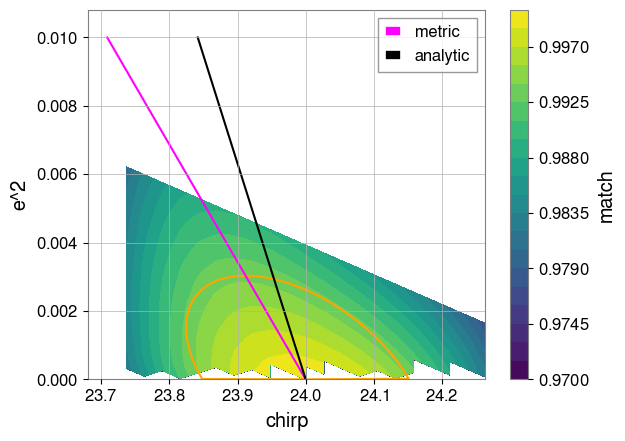

In [9]:
# Plot match grid
plt.close()
%matplotlib inline
plt.tricontourf(e2_chirp_mat.samples[1], e2_chirp_mat.samples[0], e2_chirp_mat['match'], levels=np.linspace(0.97, 1, 21))
plt.colorbar(label='match')

# Get extreme point and ellipse of metric
base_pars = {'ecc2': 0, 'chirp_mass': 24}
extreme_point = find_extreme_point(g_e2_chirp, 0.01, 'ecc2', base_pars)
ellipse = g_e2_chirp.generate_ellipse(npts=1000, scale=1)
plt.plot(ellipse['chirp_mass'], ellipse['ecc2'], c='orange')
plt.plot([base_pars['chirp_mass'], extreme_point['chirp_mass']], [base_pars['ecc2'], extreme_point['ecc2']], c='magenta', label='metric')

# Plot 'analytic' degeneracy line
e_vals = np.linspace(0,0.1,101)
chirp_vals = chirp_degeneracy_line(base_pars['chirp_mass'], e_vals, sample_rate=4096, f_low=20, q=2, f_match=20, return_delta_m=False)
plt.plot(chirp_vals, e_vals**2, c='k', label='analytic')
plt.xlabel('chirp')
plt.ylabel('e^2')
plt.ylim(0)
plt.legend()

These two degeneracy lines are fairly consistent for these small changes in parameters space, and the line derived from the metric actually seems to fit the match background better here.

# 2D example (ecc^2, eta)

Now let's try eccentricity with symmetric mass ratio.

In [10]:
if not load_metric:

    # Defines PSD settings
    ifos = ['H1']
    psds = {'H1': 'aLIGOZeroDetHighPower',
            'f_low': 20,
            'f_high': 8192,
            'length': 32
            }
    snr = 18
    psds['delta_f'] = 1. / psds['length']
    approximant = 'teobresums'
    
    # Calculates PSD
    pycbc_psd = {}
    for ifo in ifos:
        pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                    psds['f_low'])
    pycbc_psd['harm'] = 1. / sum([1. / pycbc_psd[ifo] for ifo in ifos])
    
    # Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
    pars = {'chirp_mass':24, 'symmetric_mass_ratio':2/9, 'ecc2': 0, 'spin_1z': 0, 'spin_2z': 0, 'f_ref':20}
    par_dirs = ['ecc2', 'symmetric_mass_ratio']
    
    g_e2_eta = find_metric_and_eigendirections(pars, par_dirs, snr=snr, f_low=psds['f_low'], psd=pycbc_psd['harm'], approximant=approximant)
    g_e2_eta.calculate_evecs()

In [11]:
if not load_metric:

    # Generate match grid
    e2_eta_mat = g_e2_eta.generate_match_grid(npts=21, scale=2)

In [12]:
metric_path = os.path.join('ellipsoid_simple_pe_metrics', 'g_e2_eta')
grid_path = os.path.join('ellipsoid_simple_pe_metrics', 'e2_eta_mat')

if load_metric:
    # Load metric and match grid
    with open(metric_path, 'rb') as fp:
        g_e2_eta = pickle.load(fp)
    with open(grid_path, 'rb') as fp:
        e2_eta_mat = pickle.load(fp)
else:
    # Save metric and match grid
    with open(metric_path, 'wb') as fp:
        pickle.dump(g_e2_eta, fp)
    with open(grid_path, 'wb') as fp:
        pickle.dump(e2_eta_mat, fp)

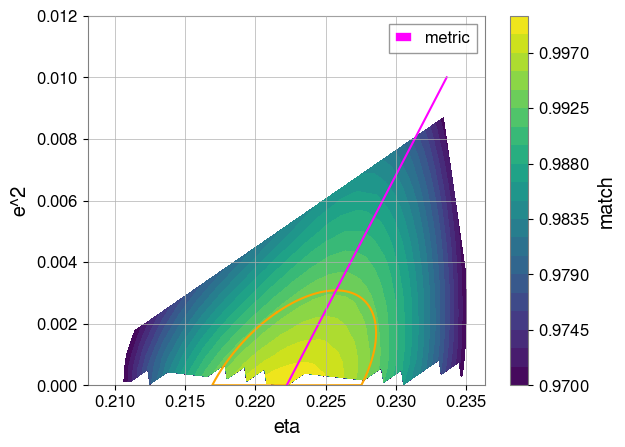

In [13]:
# Plot match grid
plt.close()
%matplotlib inline
plt.tricontourf(e2_eta_mat.samples[1], e2_eta_mat.samples[0], e2_eta_mat['match'], levels=np.linspace(0.97, 1, 21))
plt.colorbar(label='match')

# Get extreme point and ellipse of metric
base_pars = {'ecc2': 0, 'symmetric_mass_ratio': 2/9}
extreme_point = find_extreme_point(g_e2_eta, 0.01, 'ecc2', base_pars)
ellipse = g_e2_eta.generate_ellipse(npts=1000, scale=1)
plt.plot(ellipse['symmetric_mass_ratio'], ellipse['ecc2'], c='orange')
plt.plot([base_pars['symmetric_mass_ratio'], extreme_point['symmetric_mass_ratio']], [base_pars['ecc2'], extreme_point['ecc2']], c='magenta', label='metric')

# Plot formatting
plt.xlabel('eta')
plt.ylabel('e^2')
plt.ylim(0,0.012)
plt.legend()

# 3D example (ecc^2, chirp mass, eta)

Now let's try a 3d example with all of the parameters so far. This will not only let us check that higher dimensions work, but also see the effect of letting mass ratio vary on the degeneracy line between eccentricity and chirp mass.

In [14]:
if not load_metric:

    # Defines PSD settings
    ifos = ['H1']
    psds = {'H1': 'aLIGOZeroDetHighPower',
            'f_low': 20,
            'f_high': 8192,
            'length': 32
            }
    snr = 18
    psds['delta_f'] = 1. / psds['length']
    approximant = 'teobresums'
    
    # Calculates PSD
    pycbc_psd = {}
    for ifo in ifos:
        pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                    psds['f_low'])
    pycbc_psd['harm'] = 1. / sum([1. / pycbc_psd[ifo] for ifo in ifos])
    
    # Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
    pars = {'chirp_mass':24, 'symmetric_mass_ratio':2/9, 'ecc2': 0, 'spin_1z': 0, 'spin_2z': 0, 'f_ref':20}
    par_dirs = ['ecc2', 'chirp_mass', 'symmetric_mass_ratio']
    
    g_e2_chirp_eta = find_metric_and_eigendirections(pars, par_dirs, snr=snr, f_low=psds['f_low'], psd=pycbc_psd['harm'], approximant=approximant)
    g_e2_chirp_eta.calculate_evecs()

In [15]:
if not load_metric:

    # Get match grid for metric projected to ecc2/chirp space
    g_e2_chirp_eta.project_metric(['ecc2', 'chirp_mass'])
    e2_chirp_eta_proj_mat = g_e2_chirp_eta.generate_match_grid(npts=21, projected=True, scale=2)

In [16]:
metric_path = os.path.join('ellipsoid_simple_pe_metrics', 'g_e2_chirp_eta')
grid_path = os.path.join('ellipsoid_simple_pe_metrics', 'e2_chirp_eta_proj_mat')

if load_metric:
    # Load metric and match grid
    with open(metric_path, 'rb') as fp:
        g_e2_chirp_eta = pickle.load(fp)
    with open(grid_path, 'rb') as fp:
        e2_chirp_eta_proj_mat = pickle.load(fp)
else:
    # Save metric and match grid
    with open(metric_path, 'wb') as fp:
        pickle.dump(g_e2_chirp_eta, fp)
    with open(grid_path, 'wb') as fp:
        pickle.dump(e2_chirp_eta_proj_mat, fp)

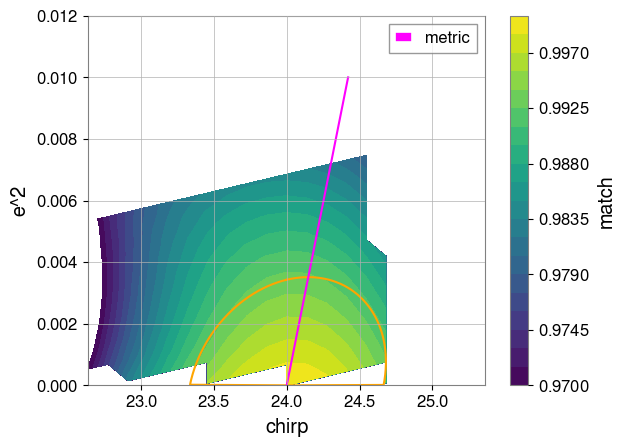

In [17]:
# Plot projected match grid
plt.close()
%matplotlib inline
plt.tricontourf(e2_chirp_eta_proj_mat.samples[1], e2_chirp_eta_proj_mat.samples[0], e2_chirp_eta_proj_mat['match'], levels=np.linspace(0.97, 1, 21))
plt.colorbar(label='match')

# Get extreme point and ellipse of metric
base_pars = {'ecc2': 0, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9}
extreme_point = find_extreme_point(g_e2_chirp_eta, 0.01, 'ecc2', base_pars)
ellipse_proj = g_e2_chirp_eta.generate_ellipse(npts=1000, projected=True, scale=1)

# Plot projected metric and degeneracy line for ecc2 against chirp mass
plt.plot(ellipse_proj['chirp_mass'], ellipse_proj['ecc2'], c='orange')
plt.plot([base_pars['chirp_mass'], extreme_point['chirp_mass']], [base_pars['ecc2'], extreme_point['ecc2']], c='magenta', label='metric')
plt.xlabel('chirp')
plt.ylabel('e^2')
plt.ylim(0,0.012)
plt.legend()
plt.show()

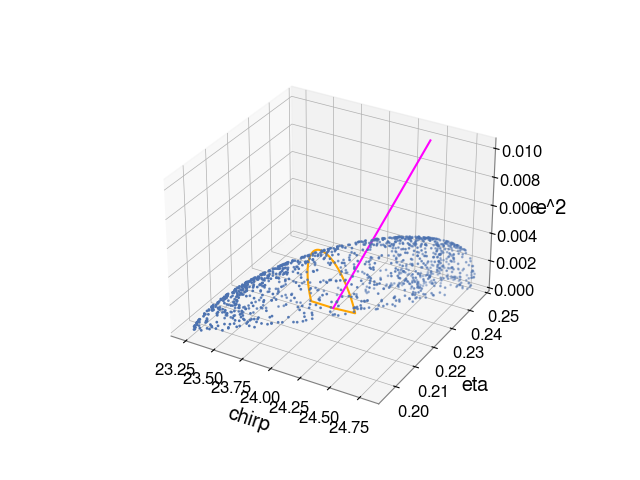

In [18]:
# Setup 3d plot
plt.close()
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
base_pars = {'ecc2': 0, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9}
extreme_point = find_extreme_point(g_e2_chirp_eta, 0.01, 'ecc2', base_pars)
ellipse_3d = generate_ellipsoid(g_e2_chirp_eta, base_pars, npts=2500)
ellipse_e2_chirp = g_e2_chirp.generate_ellipse(npts=100, scale=1.3)

# Cut unphysical parts of 3d ellipsoid
keep_inds = np.where(np.logical_and(ellipse_3d['ecc2']>=0, ellipse_3d['symmetric_mass_ratio']<=0.25))[0]
for key in ellipse_3d.keys():
    ellipse_3d[key] = ellipse_3d[key][keep_inds]

# Plot 3d ellipsoid, 2d ellipse with fixed symmetric mass ratio, and degeneracy line
ax.scatter(ellipse_3d['chirp_mass'], ellipse_3d['symmetric_mass_ratio'], ellipse_3d['ecc2'], s=1, c='b')
ax.plot(ellipse_e2_chirp['chirp_mass'], np.full(len(ellipse_e2_chirp['ecc2']), 2/9), ellipse_e2_chirp['ecc2'], c='orange')
chirp_line = np.linspace(base_pars['chirp_mass'], extreme_point['chirp_mass'], 101)
eta_line = np.linspace(base_pars['symmetric_mass_ratio'], extreme_point['symmetric_mass_ratio'], 101)
e2_line = np.linspace(base_pars['ecc2'], extreme_point['ecc2'], 101)
ax.plot(chirp_line, eta_line, e2_line, c='magenta', label='metric')

# Plot formatting
ax.set_xlabel('chirp')
ax.set_ylabel('eta')
ax.set_zlabel('e^2')
ax.set_zlim(0,)
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], 0.25)
plt.show()

# 4D example (ecc^2, chirp mass, eta, chi eff)

Finally let's try the full 4d parameter space eccentricity, chirp mass, symmetric mass ratio, and chi effective. We will vary chi eff here, which simple pe 'under the hood' places equal spin onto chi1 and chi2.

In [19]:
if not load_metric:

    # Defines PSD settings
    ifos = ['H1']
    psds = {'H1': 'aLIGOZeroDetHighPower',
            'f_low': 20,
            'f_high': 8192,
            'length': 32
            }
    snr = 18
    psds['delta_f'] = 1. / psds['length']
    approximant = 'teobresums'
    
    # Calculates PSD
    pycbc_psd = {}
    for ifo in ifos:
        pycbc_psd[ifo] = psd.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                    psds['f_low'])
    pycbc_psd['harm'] = 1. / sum([1. / pycbc_psd[ifo] for ifo in ifos])
    
    # Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
    pars = {'chirp_mass':24, 'symmetric_mass_ratio':2/9, 'ecc2': 0, 'chi_eff': 0, 'f_ref':20}
    par_dirs = ['ecc2', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
    
    g_e2_chirp_eta_chi = find_metric_and_eigendirections(pars, par_dirs, snr=snr, f_low=psds['f_low'], psd=pycbc_psd['harm'], approximant=approximant)
    g_e2_chirp_eta_chi.calculate_evecs()

In [20]:
if not load_metric:

    # Get match grid for metric projected to ecc2/chirp space
    g_e2_chirp_eta_chi.project_metric(['ecc2', 'chirp_mass'])
    e2_chirp_eta_chi_proj_mat = g_e2_chirp_eta_chi.generate_match_grid(npts=21, projected=True, scale=2)

In [21]:
metric_path = os.path.join('ellipsoid_simple_pe_metrics', 'g_e2_chirp_eta_chi')
grid_path = os.path.join('ellipsoid_simple_pe_metrics', 'e2_chirp_eta_chi_proj_mat')

if load_metric:
    # Load metric and match grid
    with open(metric_path, 'rb') as fp:
        g_e2_chirp_eta_chi = pickle.load(fp)
    with open(grid_path, 'rb') as fp:
        e2_chirp_eta_chi_proj_mat = pickle.load(fp)
else:
    # Save metric and match grid
    with open(metric_path, 'wb') as fp:
        pickle.dump(g_e2_chirp_eta_chi, fp)
    with open(grid_path, 'wb') as fp:
        pickle.dump(e2_chirp_eta_chi_proj_mat, fp)

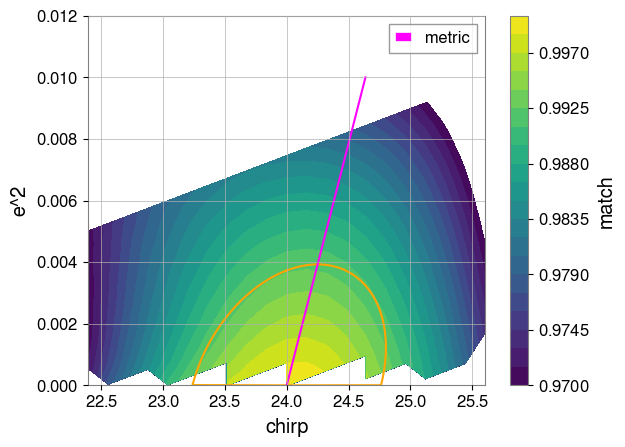

In [22]:
# Plot projected match grid
plt.close()
%matplotlib inline
plt.tricontourf(e2_chirp_eta_chi_proj_mat.samples[1], e2_chirp_eta_chi_proj_mat.samples[0], e2_chirp_eta_chi_proj_mat['match'], levels=np.linspace(0.97, 1, 21))
plt.colorbar(label='match')

# Get extreme point and ellipse of metric
base_pars = {'ecc2': 0, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
extreme_point = find_extreme_point(g_e2_chirp_eta_chi, 0.01, 'ecc2', base_pars)
ellipse_proj = g_e2_chirp_eta_chi.generate_ellipse(npts=1000, projected=True, scale=1)

# Plot projected metric and degeneracy line for ecc2 against chirp mass
plt.plot(ellipse_proj['chirp_mass'], ellipse_proj['ecc2'], c='orange')
plt.plot([base_pars['chirp_mass'], extreme_point['chirp_mass']], [base_pars['ecc2'], extreme_point['ecc2']], c='magenta', label='metric')
plt.xlabel('chirp')
plt.ylabel('e^2')
plt.ylim(0,0.012)
plt.legend()
plt.show()

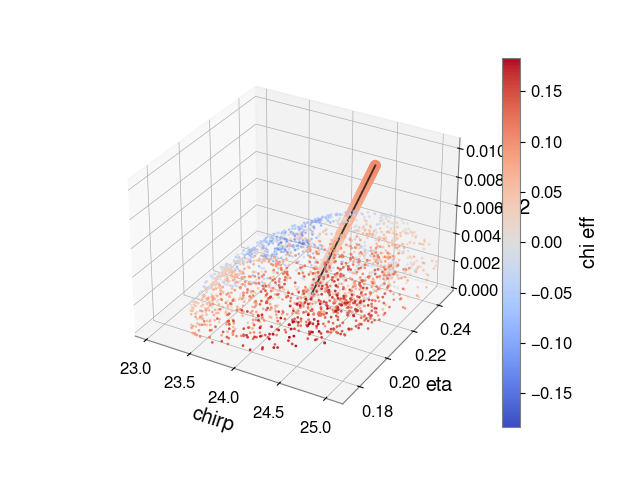

In [23]:
# Setup 4d plot
plt.close()
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
base_pars = {'ecc2': 0, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
extreme_point = find_extreme_point(g_e2_chirp_eta_chi, 0.01, 'ecc2', base_pars)
ellipse_4d = generate_ellipsoid(g_e2_chirp_eta_chi, base_pars, npts=5000)
ellipse_3d = generate_ellipsoid(g_e2_chirp_eta, base_pars, npts=2500, scale=1.2)
ellipse_e2_chirp = g_e2_chirp.generate_ellipse(npts=100, scale=1.3*1.2)

# Cut unphysical parts of 4d ellipsoid
keep_inds = np.where(np.logical_and(ellipse_4d['ecc2']>=0, ellipse_4d['symmetric_mass_ratio']<=0.25))[0]
for key in ellipse_4d.keys():
    ellipse_4d[key] = ellipse_4d[key][keep_inds]

# Get color scale and plot 4d ellipsoid
cm = plt.get_cmap('coolwarm')
c_max = np.max([np.abs(np.min(ellipse_4d['chi_eff'])), np.abs(np.max(ellipse_4d['chi_eff']))])
c_min = -1*c_max
sc = ax.scatter(ellipse_4d['chirp_mass'], ellipse_4d['symmetric_mass_ratio'], ellipse_4d['ecc2'], c=ellipse_4d['chi_eff'], s=1, cmap=cm, vmin=c_min, vmax=c_max)
plt.colorbar(sc, label='chi eff')

# Cut unphysical parts of 3d ellipsoid
keep_inds = np.where(np.logical_and(ellipse_3d['ecc2']>=0, ellipse_3d['symmetric_mass_ratio']<=0.25))[0]
for key in ellipse_3d.keys():
    ellipse_3d[key] = ellipse_3d[key][keep_inds]

# # Plot 3d ellipsoid, 2d ellipse with fixed parameters
# ax.scatter(ellipse_3d['chirp_mass'], ellipse_3d['symmetric_mass_ratio'], ellipse_3d['ecc2'], s=1, c='orange')
# ax.plot(ellipse_e2_chirp['chirp_mass'], np.full(len(ellipse_e2_chirp['ecc2']), 2/9), ellipse_e2_chirp['ecc2'], c='magenta')

# Plot degeneracy line with color
chirp_line = np.linspace(base_pars['chirp_mass'], extreme_point['chirp_mass'], 101)
eta_line = np.linspace(base_pars['symmetric_mass_ratio'], extreme_point['symmetric_mass_ratio'], 101)
e2_line = np.linspace(base_pars['ecc2'], extreme_point['ecc2'], 101)
chi_line = np.linspace(base_pars['chi_eff'], extreme_point['chi_eff'], 101)
ax.scatter(chirp_line, eta_line, e2_line, c=chi_line, s=50, cmap=cm, vmin=c_min, vmax=c_max)
ax.scatter(chirp_line, eta_line, e2_line, c='k', marker='.', s=1, alpha=0.7)

# Plot formatting
ax.set_xlabel('chirp')
ax.set_ylabel('eta')
ax.set_zlabel('e^2')
ax.set_zlim(0,)
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], 0.25)
plt.show()

As a sanity check let's plot the 4d hypersphere to check it makes sense.

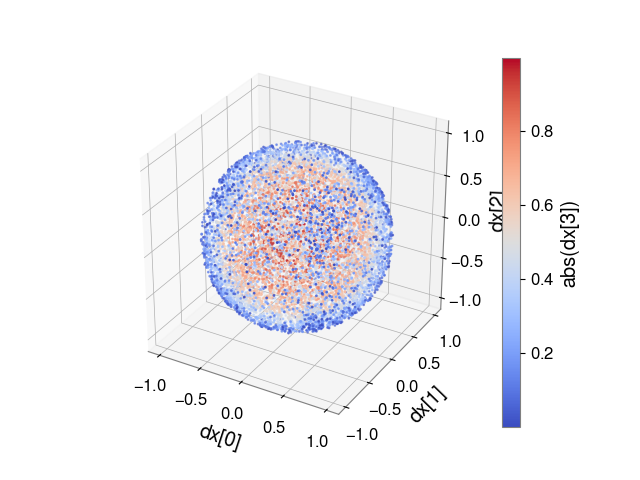

In [24]:
# Points on an 4-dimensional hypersphere
points = np.random.rand(4, 10000)*2-1
points /= np.linalg.norm(points, axis=0)

# Plot in 4d
plt.close()
%matplotlib widget
ax = plt.figure().add_subplot(projection='3d')
cm = plt.get_cmap('coolwarm')
c_min, c_max = np.min(np.abs(points[3])), np.max(np.abs(points[3]))
sc = ax.scatter(points[0], points[1], points[2], c=np.abs(points[3]), s=1, cmap=cm, vmin=c_min, vmax=c_max)

# Plot formatting
plt.colorbar(sc, label='abs(dx[3])')
ax.set_xlabel('dx[0]')
ax.set_ylabel('dx[1]')
ax.set_zlabel('dx[2]')
ax.set_aspect('equal')
plt.show()